# Representing image using watershed segmentation on connected components and local Gaussian fit

In [1]:
%load_ext autoreload
%autoreload
%matplotlib inline

In [2]:
import h5py
import dpmeans
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from skimage.feature import peak_local_max
from skimage.util import img_as_float, img_as_uint
from skimage.measure import label
from skimage.segmentation import watershed, random_walker
from scipy import ndimage
from scipy.stats import multivariate_normal

from otimage import readers

### Parameters

In [3]:
# Relative threshold applied to image
THRESHOLD_REL = 0.2

# Minimum number of pixels allowed in identified cell
CELL_MIN_SIZE = 50

### Load Zimmer data

In [4]:
# Path to file containing Zimmer data
in_fpath = '/home/mn2822/Desktop/WormOT/data/zimmer/mCherry_v00065-01581.hdf5'

# Index of frame to use
t_frame = 500

with readers.ZimmerReader(in_fpath) as reader:
    frame = reader.get_frame(t_frame)

### Select section of frame for test image

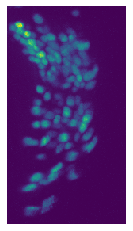

In [5]:
# Section of XY plane where head is found
head_x = (500, 650)
head_y = (250, 525)
head_z = (0, 33)

# Extract section
img = frame[head_x[0]:head_x[1], head_y[0]:head_y[1], head_z[0]:head_z[1]]
img = img_as_float(img)

# Compute image min and max
img_min = np.min(img)
img_max = np.max(img)

# Display max projection
plt.imshow(np.max(img, 2).T);
plt.axis('off');

### Apply threshold to image

**TODO: Replace this with thresholding algorithm from `skimage`**

In [6]:
# Apply threshold 
threshold_abs = img_min + THRESHOLD_REL * (img_max - img_min)
idx_below_th = img < threshold_abs
img_th = np.copy(img)
img_th[idx_below_th] = 0.0

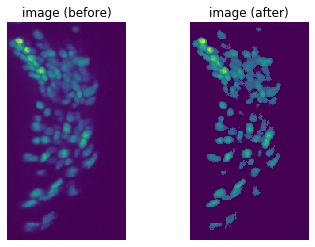

In [7]:
fig = plt.figure()

plt.subplot(121)
plt.imshow(np.max(img, 2).T);
plt.title('image (before)')
plt.axis('off')

plt.subplot(122)
plt.imshow(np.max(img_th, 2).T);
plt.title('image (after)')
plt.axis('off');

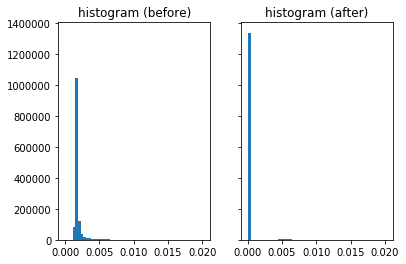

In [8]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)

axs[0].hist(img.flatten(), 50)
axs[0].set_title('histogram (before)')

axs[1].hist(img_th.flatten(), 50);
axs[1].set_title('histogram (after)');

### Find local peaks

In [9]:
peaks = peak_local_max(img_th, min_distance=2)

#### Plot slices of original image with identified local peaks

In [10]:
def plot_slice_cells(img, cells, z_min, width, ax, vmin=None, vmax=None):
    
    if vmin is None:
        vmin = np.min(img)
    if vmax is None:
        vmax = np.max(img)
    
    z_max = min(z_min + width, img.shape[2])

    img_sl = img[:, :, z_min:z_max]
    cells_sl_idx = (cells[:, 2] >= z_min) & (cells[:, 2] < z_max)
    cells_sl = cells[cells_sl_idx]
    
    ax.imshow(np.max(img_sl, 2).T, vmin=vmin, vmax=vmax);
    ax.scatter(cells_sl[:, 0], cells_sl[:, 1], marker='*', color='r')
    ax.axis('off');
    ax.set_title(f'z: {z_min}-{z_max}')

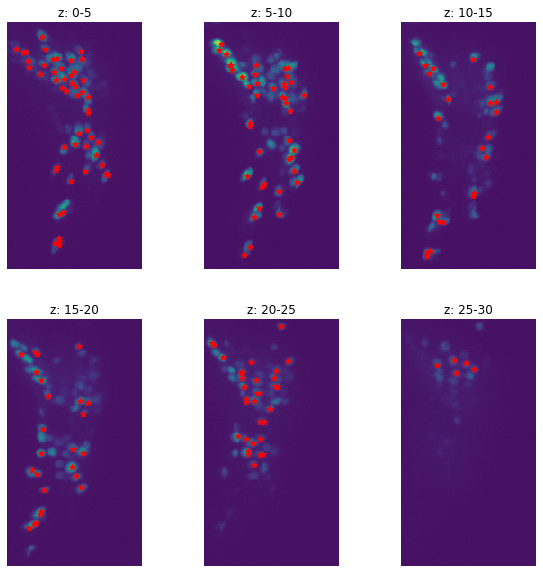

In [11]:
fig, axs = plt.subplots(
    2, 3, 
    sharex=True, sharey=True, 
    figsize=(10, 10)
)

for s in range(0, 6):
    z_min = 5 * s
    width = 5
    ax = axs.flatten()[s]
    plot_slice_cells(img, peaks, z_min, width, ax, vmin=img_min, vmax=img_max)

#### Widget

In [12]:
z_min_widget = widgets.IntSlider(min=0, max=img.shape[2] - 1, step=1, value=0)
width_widget = widgets.IntSlider(min=1, max=img.shape[2], step=1, value=1)

@widgets.interact(z_min=z_min_widget, width=width_widget)
def slice_peak_widget(z_min, width):
    
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    plot_slice_cells(img, peaks, z_min, width, ax, vmin=img_min, vmax=img_max)

interactive(children=(IntSlider(value=0, description='z_min', max=32), IntSlider(value=1, description='width',…

### Extract connected components from image

To speed up our segmentation process, we split the image into connected components before running segmentation. 

In [13]:
# Compute connected components of image (binarize using earlier threshold)
img_binary = np.greater(img_th, 0).astype(np.int)
img_labels = label(img_binary)

# Component labels for each peak
peak_cmp_labels = img_labels[peaks[:, 0], peaks[:, 1], peaks[:, 2]]

# Only components we care about are ones that contain local peaks
all_cmp_labels = np.sort(np.unique(peak_cmp_labels)).tolist()

cmp_labels = []
cmp_peaks = []
cmp_footprints = []

for c_label in all_cmp_labels:

    c_peaks = peaks[peak_cmp_labels == c_label]
    c_footprint = np.equal(img_labels, c_label)
    
    if np.count_nonzero(c_footprint) >= CELL_MIN_SIZE:
        
        cmp_labels.append(c_label)
        cmp_peaks.append(c_peaks)
        cmp_footprints.append(c_footprint)

n_cmps = len(cmp_labels)

#### Viewing widget

In [14]:
@widgets.interact(
    component=widgets.IntSlider(min=0, max=n_cmps - 1, step=1, value=0)
)
def cell_label_widget(component):
    
    c_label = cmp_labels[component]
    c_peaks = cmp_peaks[component]
    c_img = cmp_footprints[component].astype(np.int)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(np.max(img, 2).T, cmap='gray')
    plt.imshow(np.max(c_img, 2).T, alpha=0.5)
    plt.scatter(c_peaks[:, 0], c_peaks[:, 1], marker='*', color='red');

interactive(children=(IntSlider(value=0, description='component', max=41), Output()), _dom_classes=('widget-in…

### Run segmentation on each connected component

In [15]:
cmp_seg = []
cmp_num_peaks = []

for cmp in range(n_cmps):
    
    c_label = cmp_labels[cmp]
    c_peaks = cmp_peaks[cmp]
    c_footprint = cmp_footprints[cmp]
    
    # Pixels are marked 'unlabeled' by default
    markers = np.zeros_like(img, dtype=np.int)
    
    # All pixels outside of component are removed from graph
    markers[~c_footprint] = -1
    
    # Each peak is marked with its own positive integer label
    mark_vals = np.arange(c_peaks.shape[0]) + 1
    markers[c_peaks[:, 0], c_peaks[:, 1], c_peaks[:, 2]] = mark_vals

    # Segment component using random walk-based algorithm
    cmp_seg.append(random_walker(img, markers))
    
    # Store number of peaks
    cmp_num_peaks.append(c_peaks.shape[0])

#### Plot cells

In [16]:
cmp = 0
img_cmp = np.copy(img)
img_cmp[~cmp_footprints[cmp]] = 0

@widgets.interact(
    cell=widgets.IntSlider(min=0, max=cmp_num_peaks[cmp] - 1, step=1, value=0)
)
def cell_label_widget(cell):
    
    c_label = cell + 1
    c_img = np.equal(cmp_seg[cmp], c_label)
    c_peak = cmp_peaks[cmp][cell]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(np.max(img_cmp, 2).T, cmap='gray')
    plt.imshow(np.max(c_img, 2).T, alpha=0.5)
    plt.scatter(c_peak[0], c_peak[1], marker='*', color='red')

interactive(children=(IntSlider(value=0, description='cell', max=1), Output()), _dom_classes=('widget-interact…

### Fit Gaussians to component segments

In [17]:
xg, yg, zg = np.mgrid[0:img.shape[0], 0:img.shape[1], 0:img.shape[2]]
grid = np.stack((xg, yg, zg), axis=-1)

cell_cmps = []
cell_segs = []
cell_means = []
cell_covs = []

for cmp in range(n_cmps):
    for cell in range(len(cmp_peaks[cmp])):
        
        c_label = cell + 1
        c_pixel_idx = np.equal(cmp_seg[cmp], c_label)
        
        if np.count_nonzero(c_pixel_idx) >= CELL_MIN_SIZE:
            
            pos_vals = grid[c_pixel_idx]
            pix_vals = img[c_pixel_idx]
            
            # Compute mean and covariance (adding ridge to covariance for conditioning)
            mean = np.average(pos_vals, axis=0, weights=pix_vals)
            cov = np.cov(pos_vals, aweights=pix_vals, rowvar=False) + np.eye(3) * 1e-5
            cell_means.append(mean)
            cell_covs.append(cov)
        
n_cells = len(cell_means)
cell_gauss_fits = []

for cell in range(n_cells):
    
    rv = multivariate_normal(cell_means[cell], cell_covs[cell])
    cell_gauss_fits.append(rv.pdf(grid))

In [18]:
@widgets.interact(
    cell=widgets.IntSlider(min=0, max=n_cells - 1, step=1, value=0)
)
def cell_label_widget(cell):
    
    gauss_img = cell_gauss_fits[cell]
    plt.figure(figsize=(10, 10))
    plt.imshow(np.max(gauss_img, 2).T)

interactive(children=(IntSlider(value=0, description='cell', max=120), Output()), _dom_classes=('widget-intera…

### Compute coefficients for Gaussians 

In [19]:
cell_vecs = np.array([c.flatten() for c in cell_gauss_fits]).T
img_vec = img.reshape((-1, 1))
coeff, r_sum, _, _  = np.linalg.lstsq(cell_vecs, img_vec, rcond=None)

approx_vec = cell_vecs @ coeff
approx_img = approx_vec.reshape(img.shape)

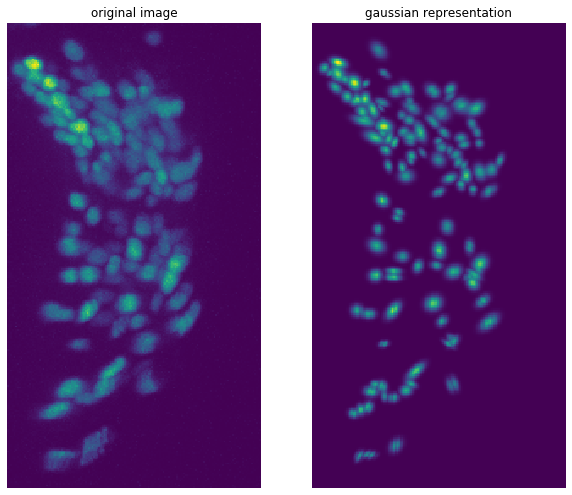

In [20]:
plt.figure(figsize=(10, 10))

plt.subplot(121)
plt.imshow(np.max(img, 2).T)
plt.axis('off')
plt.title('original image')

plt.subplot(122)
plt.imshow(np.max(approx_img, 2).T)
plt.axis('off')
plt.title('gaussian representation')

plt.savefig('gaussian_representation.png')